In [60]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/yiwenwu/anaconda3/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Exercise 5

In [80]:
def simulate(Δt, x, u):
    x += Δt * u
    return x

In [81]:
def control_5(k, pd, pt):
    return (k * (pd - pt))

In [82]:
tf = 20.
Δt = 0.01    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval


# Initial location
pt = array([1., 2.])
pt_log = [copy(pt)]

k = 1.0

# Desired location
pd = array([3., 3.])



for t in time:
    u = control_5(k, pd, pt)    
    pt = simulate(Δt, pt, u)
    pt_log.append(copy(pt))
    
pt_log = array(pt_log)

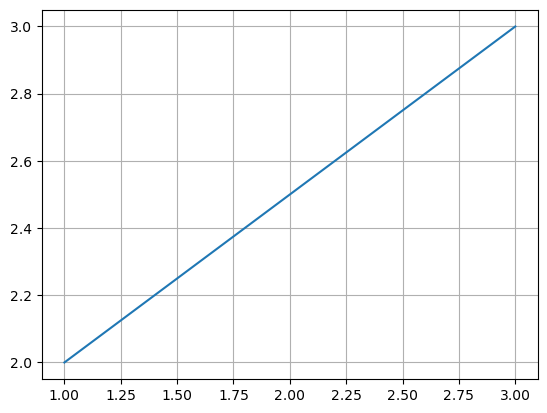

In [83]:
grid()
plot(pt_log[:,0], pt_log[:,1])

### Exercise 6

In [84]:
tf = 20.
Δt = 0.01    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval


# Initial location
pt = array([-3., -3.])
pt_log = [copy(pt)]

k = 1.0

# Desired location
pds = array([array([-2.7, 2.8]), array([3., -2.6]), array([2.8, 2.9]), array([0., 0.])])

for pd in pds:
    for t in time:
        u = control_5(k, pd, pt)    
        pt = simulate(Δt, pt, u)
        pt_log.append(copy(pt))
    
pt_log = array(pt_log)

([<matplotlib.axis.YTick at 0x127b6db10>,
 [Text(0, -3, '−3'),
  Text(0, -2, '−2'),
  Text(0, -1, '−1'),
  Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3')])

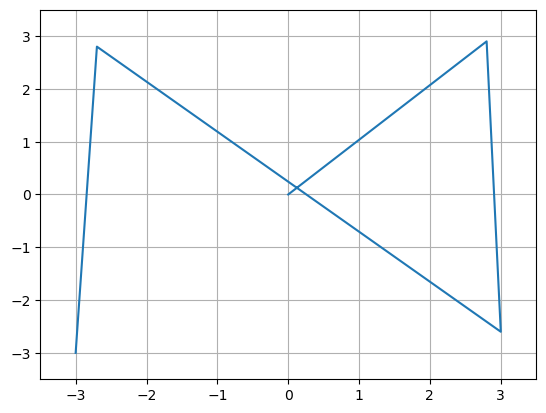

In [85]:
grid()
plot(pt_log[:,0], pt_log[:,1])

# Set x and y limits
xlim([-3.5, 3.5])
ylim([-3.5, 3.5])

# Set x and y ticks
xticks([-3, -2, -1, 0, 1, 2, 3])
yticks([-3, -2, -1, 0, 1, 2, 3])

### Part2: 1. Free Fall

In [86]:
# Perfect sensor
def sense(x):
    return x

In [87]:
def simulate_freefall(Δt, x, u, m=1, g=9.8):
    # Control input affects the acceleration
    dx = array([x[3], x[4], x[5], u[0]/m, u[1]/m, u[2]/m])
    
    # Include the gravity in the acceleration in z
    dx[5] += - g
        
    # Euler integration
    x += Δt * dx
    
    # Simulate the floor (Plastic collision)    
    if x[2] < 0:        
        x[2] = 0  # z = 0
        x[5] = 0  # vz = 0
    
    return x

In [88]:
def control(t, y):    
    ux = 0
    uy = 0
    uz = 0
    return [ux, uy, uz]

In [89]:
tf = 3.
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval


# Initial conditions
x = array([0., 0., 10., 0.,0.,0.])
x_log = [copy(x)]

for t in time:    
    y = sense(x)
    u = control(t, y)
    x = simulate_freefall(Δt, x, u)
    x_log.append(copy(x))
    
x_log = array(x_log)

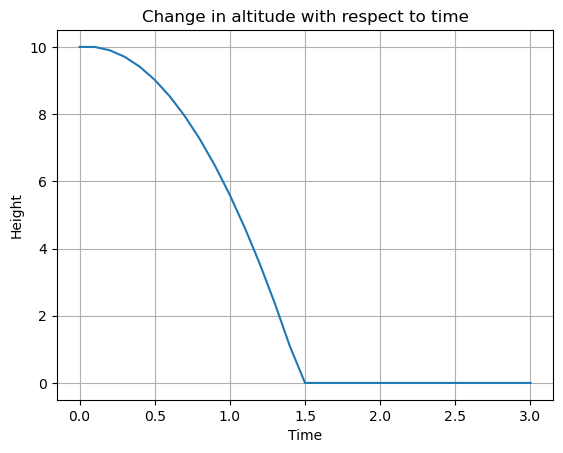

In [90]:
fig, ax = plt.subplots()
ax.plot(time, x_log[:-1,2])
ax.set(title="Change in altitude with respect to time", xlabel="Time", ylabel="Height")
ax.grid()


# axes().set_ylabel("Time z")

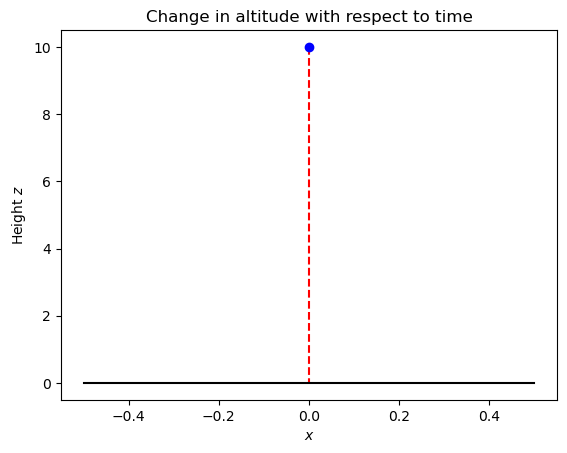

In [91]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
    


fig, ax = plt.subplots()

def animate(t):
    ax.clear()
    
    # Path
    ax.plot(x_log[:,0], x_log[:,2], 'r--')
    
    # Initial conditions
    ax.plot(x_log[t,0], x_log[t,2], 'bo')
    
    # Plot floor
    ax.plot([-0.5,0.5], [0,0], 'k-')
    
    ax.set(title="Change in altitude with respect to time", xlabel="$x$", ylabel="Height $z$")

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=60)

HTML(anim.to_jshtml())

### Part2: 2. fb=9.0

In [92]:
def simulate_fb(Δt, x, u, m=1, g=9.8, fb=9.0):
    # Control input affects the acceleration
    dx = array([x[3], x[4], x[5], u[0]/m, u[1]/m, (u[2] + fb - m*g)/m])
    
    # Euler integration
    x += Δt * dx
    
    # Simulate the floor (Plastic collision)    
    if x[2] < 0:        
        x[2] = 0  # z = 0
        x[5] = 0  # vz = 0
    
    return x

In [93]:
tf = 10.
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval


# Initial conditions
x = array([0., 0., 10., 0.,0.,0.])
x_log = [copy(x)]

for t in time:    
    y = sense(x)
    u = control(t, y)
    x = simulate_fb(Δt, x, u)
    x_log.append(copy(x))
    
x_log = array(x_log)

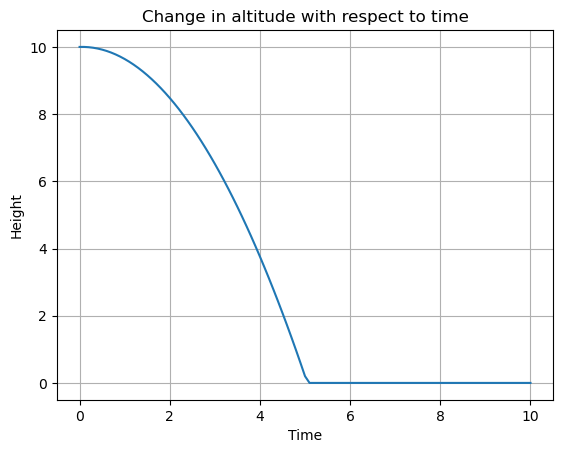

In [94]:
fig, ax = plt.subplots()
ax.plot(time, x_log[:-1,2])
ax.set(title="Change in altitude with respect to time", xlabel="Time", ylabel="Height")
ax.grid()


# axes().set_ylabel("Time z")

### Part2: 3. Height Controller

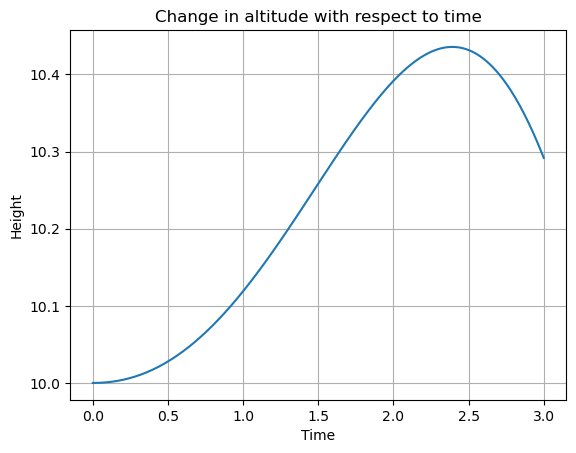

In [95]:
# PD Controller for height control
def pd_height_controller(z_desired, z_current, z_dot_current, Kp, Kd):
    """
    PD controller for height.
    
    :param z_desired: Desired height (setpoint)
    :param z_current: Current height
    :param z_dot_current: Current rate of c hange of height (velocity in z)
    :param Kp: Proportional gain
    :param Kd: Derivative gain
    :return: Control input u(t) for the height
    """
    control_input = Kp * (z_desired - z_current) + Kd * z_dot_current
    return control_input

# Simulation parameters
Kp = 2.0  # Proportional gain
Kd = 1.0  # Derivative gain
z_desired = 15.0  # Desired height
Δt = 0.01  # Time step
tf = 3.0  # Final time
time = linspace(0., tf, int(tf / Δt) + 1)  # Time array

# Initial conditions
x = array([0., 0., 10., 0., 0., 0.])  # Initial position and velocity
x_log = [x.copy()]

for t in time:
    z_current = x[2]
    z_dot_current = x[5]
    u_z = pd_height_controller(z_desired, z_current, z_dot_current, Kp, Kd)
    
    # Apply control input to simulate function (you need to modify the simulate function accordingly)
    u = array([0, 0, u_z])  # Assuming no control in x and y for this example
    x = simulate_freefall(Δt, x, u)
    
    x_log.append(x.copy())

x_log = array(x_log)

fig, ax = plt.subplots()
ax.plot(time, x_log[:-1,2])
ax.set(title="Change in altitude with respect to time", xlabel="Time", ylabel="Height")
ax.grid()


### Part2: 4. Mass Mismatch

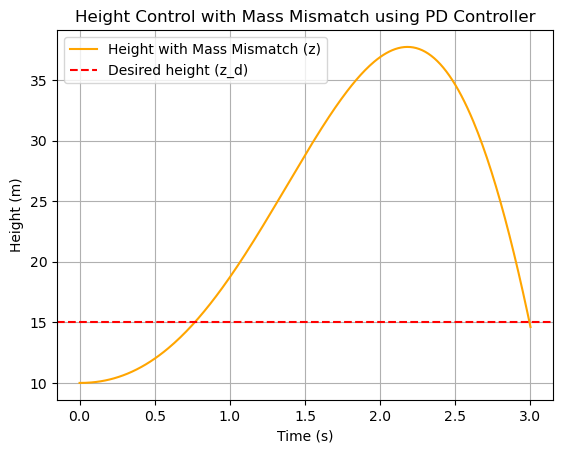

In [96]:
# Redefine the simulate function to account for the actual mass
def simulate_with_mass(Δt, x, u, actual_mass=0.8, g=9.8, fb=9.0):
    # Control input affects the acceleration
    dx = array([x[3], x[4], x[5], u[0]/actual_mass, u[1]/actual_mass, (u[2] + fb - actual_mass*g)/actual_mass])
    
    # Euler integration
    x += Δt * dx
    
    # Simulate the floor (Plastic collision)
    if x[2] < 0:        
        x[2] = 0  # z = 0
        x[5] = 0  # vz = 0
    
    return x


assumed_mass = 1.0
actual_mass = 0.8

# Re-run the simulation considering the mismatch in the assumed mass
x = array([0., 0., 10., 0., 0., 0.])  # Reset initial conditions
x_log_mismatch = [x.copy()]

for t in time[:-1]:  # Exclude the last time step to match the lengths
    z_current = x[2]
    z_dot_current = x[5]
    u_z = pd_height_controller(z_desired, z_current, z_dot_current, Kp, Kd)
    # Apply control input to simulate function with actual mass
    u = array([0, 0, u_z])  # Assuming no control in x and y
    x = simulate_with_mass(Δt, x, u, actual_mass=actual_mass)
    x_log_mismatch.append(x.copy())

x_log_mismatch = np.array(x_log_mismatch)

# Plot the results for the mass mismatch case
plt.figure()
plt.plot(time, x_log_mismatch[:, 2], label='Height with Mass Mismatch (z)', color='orange')
plt.axhline(y=z_desired, color='r', linestyle='--', label='Desired height (z_d)')
plt.title('Height Control with Mass Mismatch using PD Controller')
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.legend()
plt.grid(True)
plt.show()